In [360]:
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os

In [361]:
df = pd.read_csv("datainflacion.csv")

In [362]:
inflacionInteranual = df[["Periodo","inf_gt_interanual"]]

In [363]:
inflacionInteranual["Periodo2"] = 0
for i in range(0, len(inflacionInteranual.Periodo)):
    inflacionInteranual.iloc[i, 2] = inflacionInteranual.Periodo[1][6:10] + '-12-' + '31'


/tmp/ipykernel_899699/1607952074.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inflacionInteranual["Periodo2"] = 0
/tmp/ipykernel_899699/1607952074.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inflacionInteranual.iloc[i, 2] = inflacionInteranual.Periodo[1][6:10] + '-12-' + '31'


In [364]:
inflacionInteranual

,Periodo,inf_gt_interanual,Periodo2
0,01/01/2005,0.0904,2005-12-31
1,01/02/2005,0.0904,2005-12-31
2,01/03/2005,0.0877,2005-12-31
3,01/04/2005,0.0888,2005-12-31
4,01/05/2005,0.0852,2005-12-31
...,...,...,...
204,01/01/2022,0.0287,2005-12-31
205,01/02/2022,0.0298,2005-12-31
206,01/03/2022,0.0417,2005-12-31
207,01/04/2022,0.0462,2005-12-31


In [365]:
inflacionInteranual.index = pd.to_datetime(inflacionInteranual['Periodo'],format='%d/%m/%Y')

In [366]:
inflacionInteranual

,Periodo,inf_gt_interanual,Periodo2
Periodo,,,
2005-01-01,01/01/2005,0.0904,2005-12-31
2005-02-01,01/02/2005,0.0904,2005-12-31
2005-03-01,01/03/2005,0.0877,2005-12-31
2005-04-01,01/04/2005,0.0888,2005-12-31
2005-05-01,01/05/2005,0.0852,2005-12-31
...,...,...,...
2022-01-01,01/01/2022,0.0287,2005-12-31
2022-02-01,01/02/2022,0.0298,2005-12-31
2022-03-01,01/03/2022,0.0417,2005-12-31


In [367]:
temp = inflacionInteranual['inf_gt_interanual']

<AxesSubplot:xlabel='Periodo'>

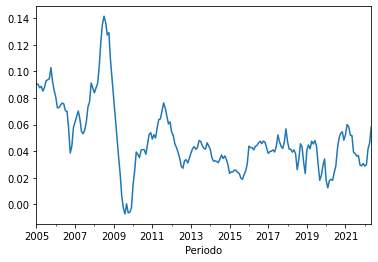

In [368]:
temp.plot()

In [369]:
def df_to_X_y(df, window_size=5):
    #Esta funcion crea el tensor a ser procesado
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [[a] for a in df_as_np[i:i+5]]
        X.append(row)
        label = df_as_np[i+5]
        y.append(label)

    return np.array(X), np.array(y)


In [370]:
window_size = 5
X, y = df_to_X_y(temp, window_size)

In [371]:
X_train, y_train = X[:140],y[:140]
X_val, y_val = X[140:180], y[140:180]
X_test, y_test = X[180:], y[180:]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((140, 5, 1), (140,), (40, 5, 1), (40,), (24, 5, 1), (24,))

In [372]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import load_model

In [373]:
model1 = Sequential()
model1.add(InputLayer((5,1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

In [374]:
model1.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 64)                16896     
                                                                 
 dense_22 (Dense)            (None, 8)                 520       
                                                                 
 dense_23 (Dense)            (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [375]:
cp = ModelCheckpoint('model1/',save_best_only=True)

In [376]:
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.01), metrics=[RootMeanSquaredError()])

In [377]:
model1.fit(X_train, y_train, validation_data=(X_val,y_val),epochs=10,callbacks=[cp])

Epoch 1/10
1/5 [=====>........................] - ETA: 8s - loss: 0.0039 - root_mean_squared_error: 0.0625

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


5/5 [==============================] - 6s 991ms/step - loss: 0.0016 - root_mean_squared_error: 0.0396 - val_loss: 1.2490e-04 - val_root_mean_squared_error: 0.0112
Epoch 2/10
1/5 [=====>........................] - ETA: 0s - loss: 7.9949e-04 - root_mean_squared_error: 0.0283

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


5/5 [==============================] - 4s 990ms/step - loss: 7.2340e-04 - root_mean_squared_error: 0.0269 - val_loss: 9.1772e-05 - val_root_mean_squared_error: 0.0096
Epoch 3/10
5/5 [==============================] - 0s 25ms/step - loss: 4.5516e-04 - root_mean_squared_error: 0.0213 - val_loss: 4.5784e-04 - val_root_mean_squared_error: 0.0214
Epoch 4/10
5/5 [==============================] - 0s 16ms/step - loss: 4.3395e-04 - root_mean_squared_error: 0.0208 - val_loss: 3.1989e-04 - val_root_mean_squared_error: 0.0179
Epoch 5/10
5/5 [==============================] - 0s 22ms/step - loss: 4.0226e-04 - root_mean_squared_error: 0.0201 - val_loss: 2.0796e-04 - val_root_mean_squared_error: 0.0144
Epoch 6/10
5/5 [==============================] - 0s 16ms/step - loss: 4.1950e-04 - root_mean_squared_error: 0.0205 - val_loss: 1.1238e-04 - val_root_mean_squared_error: 0.0106
Epoch 7/10
5/5 [==============================] - 0s 16ms/step - loss: 2.8814e-04 - root_mean_squared_error: 0.0170 - val_los

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


5/5 [==============================] - 4s 921ms/step - loss: 2.9010e-04 - root_mean_squared_error: 0.0170 - val_loss: 6.6845e-05 - val_root_mean_squared_error: 0.0082


In [378]:
best_model = load_model('model1/')

In [379]:
train_predictions = best_model.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train_Predictions':train_predictions,'Valores_Reales':y_train})

5/5 [==============================] - 0s 2ms/step


In [380]:
train_results

,Train_Predictions,Valores_Reales
0,0.076921,0.0880
1,0.076625,0.0930
2,0.077692,0.0937
3,0.079102,0.0945
4,0.080380,0.1029
...,...,...
135,0.040822,0.0456
136,0.041321,0.0476
137,0.041895,0.0467
138,0.042126,0.0423


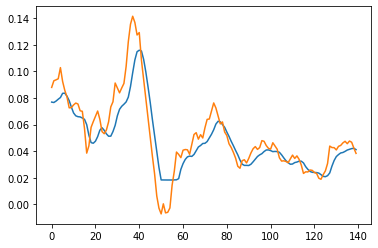

In [381]:
plt.plot(train_results['Train_Predictions'])
plt.plot(train_results['Valores_Reales'])

In [382]:
val_predictions =  model1.predict(X_val).flatten()
val_results = pd.DataFrame(data={'Val_Predictions':val_predictions, 'Actuals':y_val})

2/2 [==============================] - 0s 2ms/step


In [383]:
val_results

,Val_Predictions,Actuals
0,0.039187,0.0396
1,0.037895,0.0400
2,0.036944,0.0409
3,0.036589,0.0393
4,0.036312,0.0436
5,0.037269,0.0522
6,0.040067,0.0472
7,0.041433,0.0436
8,0.041410,0.0420
9,0.040824,0.0469


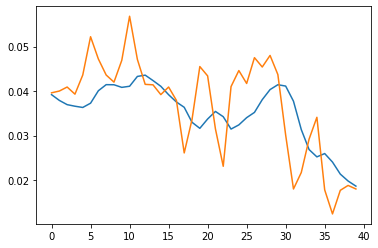

In [384]:
plt.plot(val_results['Val_Predictions'])
plt.plot(val_results['Actuals'])

In [385]:
test_predictions =  model1.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Test_Predictions':test_predictions, 'Actuals':y_test})
test_results

1/1 [==============================] - 0s 28ms/step


,Test_Predictions,Actuals
0,0.018390,0.0239
1,0.019144,0.0288
2,0.021998,0.0419
3,0.027089,0.0497
4,0.033280,0.0534
5,0.039248,0.0546
6,0.043771,0.0482
7,0.045305,0.0524
8,0.046209,0.0600
9,0.048243,0.0584


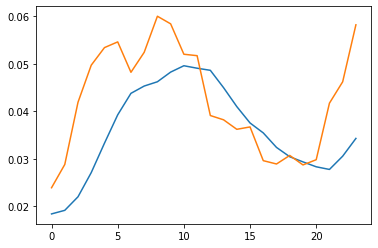

In [386]:
plt.plot(test_results['Test_Predictions'])
plt.plot(test_results['Actuals'])

In [387]:
#%reset